# Question 2

## Introduction to question 2

In the second question of this assignment, we will explore the use of local search in genome assembly.

We will use local search to assemble (construct) a large part of the nucleotide sequence of the monkeypox virus, which has been downloaded from the National Center for Biotechnology Information in the United States. Please note that no additional or specialized knowledge of biology or bioinformatics is required for this assignment. (Actually, the technical specifics of bioinformatics have been adapted and simplified for the purposes of this computer science assignment, so if you are a biologist, please do not apply preexisting knowledge to solve the problem. Furthermore, you should not attempt to search up the genome on genomic databases to "guess" the actual sequence, since we are more interested in your coding methodology rather than your attempts at reproducing a known sequence.)

This is an introductory computer science assignment and not a bioinformatics assignment; we are simply using bioinformatics as a use case to illustrate the applicability of local search to the natural sciences. Therefore, no knowledge of bioinformatics is assumed or required. In the paragraphs that follow, I will give a short crash course which will cover all the domain knowledge you will need to know in order to tackle this problem.  

For technical reasons, when we analyze the nucleotide sequence (genome) of a virus, we usually cannot “read” it in one fell swoop. We have to read the genome in parts, because the genome is usually too long for the machine to read in a single sitting. To simplify things, a “read” is a single view of part of the genome; think of it as a SUBSTRING, a partial view of the whole genome. After we have generated multiple reads of a genome, we then have to “stitch”, or combine, the different reads of the genome together. This process of stitching up reads of a genome into the final sequence is known as genome assembly. However, the different reads of the genome cannot just be concatenated like usual string concatenation. It’s not a situation where you have one read, “Hello”, and another read, “World”, and all you need to do is concatenate both strings together to make “Hello World”. Among other reasons, there are two major reasons why you can’t do so:

1. You do not know which read came first. The reads are not ordered. How do you know “Hello” came after “World”? The answer is that you don’t. Imagine how complicated this situation might be if you had more than two reads. (This is indeed our situation, where we have $n$ reads, and $n>>2$.)

2. One read may contain a substring contained in another read. Specifically, without loss of generality, part of the ending $x$ characters of a read (i.e., suffix) might also be found in the starting $x$ positions (i.e., prefix) of another read.

- A computer scientist usually creates opportunities from problems. While this may be a “problem” in that you just can’t concatenate two strings blindly, the fact that strings contain shared “substrings” is actually a very helpful clue that you can use to “join” strings together. 

- Note that the choice of the value of $x$ could be a hyperparameter decided by the computer scientist.

## Your tasks

In this part of the assignment, you will work with (simulated) reads that I have generated from the nucleotide sequence of the monkeypox virus. In reality, bioinformatics is far more complicated, but here we will work with a simplified situation. Your task is to examine the reads that I have provided for you, and from there “infer” the nucleotide sequence that might have produced those reads. 

The reads are provided in the csv file `data.csv` which simply provides a list of unique strings. Note that you should NOT assume any particular ordering of the strings in this dataframe. In fact, the strings have already been shuffled randomly. 

NOTE: You are not allowed to use `pandas` or any other libraries apart from the Python STL to load the csv file.

### Task A (3 marks): 

Create a directed graph. The nodes in the graph are the strings in the list of reads. An edge should be drawn FROM read A TO read B if and only if a suffix (of length $x$) of read A is also a prefix (obviously, also of length $x$) of read B. For the purposes of the assignment, limit the value of $x$ to between 5 and 30, both inclusive. That is, to be clear, $5\leq x\leq 30$. The weight of an edge between read A and read B should be the NEGATED value of $x$, i.e. $-x$. 

In your Jupyter notebook, please report the number of edges in your graph. Provide a barplot or histogram which shows the number of edges with different weights or weight categories. In this task, you are free to use plotting libraries such as `matplotlib` or `seaborn` to plot this graph.

As an example, if read A is "TACTAGT" and read B is "TAGTCCCCT", then an edge is drawn FROM read A TO read B (i.e., $A \rightarrow B$) with weight of $-4$. This is because the 4-suffix "TAGT" is also the 4-prefix of read B; in other words, the last 4 characters of read A (a substring of length 4) overlap with the first 4 characters of read B (a substring of length 4).

### Task B (7 marks): 

From Task A, you now have a graph which shows connections between reads based on how they overlap, in theory you could draw a path through the graph and thereby derive the full sequence (genome).

Task B asks you to use local search method(s) to determine a path through this directed graph of strings. 

- You are expected to use simulated annealing and tune the relevant configuration settings and hyperparameters. The minimum requirement is to implement simulated annealing.

- Explain tha rationale behind the choice of scheduling strategy and parameters.

- However, you may also explore other search methods in addition to simulated annealing. Marks will be awarded for effort.

Note the following constraints:

1. The path has to go through each and every vertex exactly once. For computer scientists, this constraint is reminiscent of the "Traveling Salesman's Problem", except that unlike TSP, we should not need to go back to the starting vertex again. 

2. For the purposes of neighbor generation / action selection at each node, bear in mind that a path through the graph which minimizes the total number of nucleotides in the assembled sequence is the preferred path. To state that another way, the assembled sequence should be derived from a path that goes through EACH and EVERY vertex exactly once, however we want this assembled sequence to be AS SHORT AS POSSIBLE.

3. You are not given the starting (source/origin) or ending (destination) vertex.

4. For avoidance of ambiguity, no cycles are allowed. You must not visit a vertex more than once.

5. You are not allowed to use any libraries apart from the Python Standard Library.
No import statements which import libraries outside of the Python STL should be found within your answer for Task B.

Please remember to report the assembled sequence that you obtain. Although it would be great if you can come up with a good sequence, please feel reassured that we are more interested in your APPROACH to the problem, and so you can potentially get a reasonable score on this task even if your solution is "wrong". It is the process, rather than the result, which matters more.

In [46]:
# Problem Class
class Problem:
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When you create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
        
    def actions(self, state):        raise NotImplementedError
    def result(self, state, action): raise NotImplementedError
    def is_goal(self, state):        return state == self.goal
    def action_cost(self, s, a, s1): return 1
    def h(self, node):               return 0
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

In [47]:
# Use the following Node class to generate search tree
import math
class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0, depth=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost, depth=depth)
        if self.parent:
            self.depth = self.parent.depth + 1

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return self.depth
    def __lt__(self, other): return self.path_cost < other.path_cost 

    # self defined functions
    def get_state(self): return self.state
    def get_parent(self): return self.parent
    def set_parent(self, node): 
        self.parent = node
        self.depth = self.parent.depth + 1

In [55]:
# Code to generate neighbours, value of states, etc.
import random
class TSP(Problem):
    #Implement TSP class here

    def probability(self, p):
        """Return true with probability p."""
        return p > random.uniform(0.0, 1.0)

    def exp_schedule(t = 0, k = 1000,lam = 0.03, limit = 10000):
        '''One possible temperature schedule method'''
        return lambda t: (k * math.exp(-lam * t) if t < limit else 0)
    
    def total_value(self, edges, sequences):
        '''Total value of the path'''
        value = 0
        for i in range(len(sequences) - 1):
            value += edges[sequences[i]][sequences[i+1]]
        return value
    
    def update_value(self, current_value, edges, sequences, swap1, swap2):
        if 0 < swap1 < len(sequences) - 1 and 0 < swap2 < len(sequences) - 1:
            return current_value - edges[sequences[swap1 - 1]][sequences[swap1]] - edges[sequences[swap1]][sequences[swap1 + 1]] \
            - edges[sequences[swap2 - 1]][sequences[swap2]] - edges[sequences[swap2]][sequences[swap2 + 1]] \
            + edges[sequences[swap1 - 1]][sequences[swap2]] + edges[sequences[swap2]][sequences[swap1 + 1]] \
            + edges[sequences[swap2 - 1]][sequences[swap1]] + edges[sequences[swap1]][sequences[swap2 + 1]]
        elif swap1 == 0 and 0 < swap2 < len(sequences) - 1:
            return current_value - edges[sequences[swap1]][sequences[swap1 + 1]] \
            - edges[sequences[swap2 - 1]][sequences[swap2]] - edges[sequences[swap2]][sequences[swap2 + 1]] \
            + edges[sequences[swap2]][sequences[swap1 + 1]] \
            + edges[sequences[swap2 - 1]][sequences[swap1]] + edges[sequences[swap1]][sequences[swap2 + 1]]
        elif 0 < swap1 < len(sequences) and swap2 == len(sequences) - 1:
            return current_value - edges[sequences[swap1 - 1]][sequences[swap1]] - edges[sequences[swap1]][sequences[swap1 + 1]] \
            - edges[sequences[swap2 - 1]][sequences[swap2]] \
            + edges[sequences[swap1 - 1]][sequences[swap2]] + edges[sequences[swap2]][sequences[swap1 + 1]] \
            + edges[sequences[swap2 - 1]][sequences[swap1]]
        elif swap1 == 0 and swap2 == len(sequences) - 1:
            return current_value - edges[sequences[swap1]][sequences[swap1 + 1]] \
            - edges[sequences[swap2 - 1]][sequences[swap2]] \
            + edges[sequences[swap2]][sequences[swap1 + 1]] \
            + edges[sequences[swap2 - 1]][sequences[swap1]]
        
    def simulated_annealing(self, edges, sequences=[], schedule = exp_schedule()):
        current = sequences[:]
        t = 0
        current_value = self.total_value(edges,current)
        count = 0
        
        while True:
            T = schedule(t)
            if T == 0: 
                #print("Times of change path", count)
                print("Total costs of final solution:", current_value)
                return current
            t += 1
            for k in range(100):
                swap1 = random.randint(0,len(sequences)-1)
                while True:
                    swap2 = random.randint(0,len(sequences)-1)
                    if swap2 != swap1: break
                if swap1 > swap2:
                    swap1, swap2 = swap2, swap1
                next = current[:]
                next[swap1], next[swap2] = next[swap2], next[swap1]
                next_value = self.update_value(current_value, edges, current, swap1, swap2)
                delta_E = next_value - current_value
                if delta_E < 0 or self.probability(math.exp(-delta_E / T)):
                    count += 1
                    current = next
                    current_value = next_value


## Task A: Graph Building
We constructed the following graph using the maximum overlap values of the suffix and prefix between two sequences as the weights of the edges, removing the limitation that the overlap value should $5\leq x\leq 30$. For those which do not share any sequence, we regard the weight as 0.

In [49]:
import csv
import matplotlib.pyplot as plt
# read data
data_file_name = 'data.csv'
file_data = []
with open(data_file_name) as csv_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        file_data.append(row[2])

# remove the first line
file_data.pop(0)
size = len(file_data)


edges = [[0 for _ in range(size)] for _ in range(size)]

# build graph
node_list = []
for index in range(size):
    # build node
    state = index
    node = Node(state)
    # build edge
    for old_node in node_list:  
        old_state = old_node.get_state()

        cur_str = file_data[state]
        old_str = file_data[old_state]

        rg = min(len(cur_str),len(old_str))

        for i in range(rg,-1,-1):
            # state -> old_state
            if edges[state][old_state] == 0 and cur_str[-i:] == old_str[:i]:
                edges[state][old_state] = -i
            # old_state -> state
            if edges[old_state][state] == 0 and old_str[-i:] == cur_str[:i]:
                edges[old_state][state] = -i
            if edges[state][old_state]!=0 and edges[old_state][state]!=0:
                break
    node_list.append(node)

We calculate the number of edges of every weight, then use a dictionary to store the information. As we can see from the result below, most weights are 0, which means that the sequences do not have any overlap. It is worth noting that there is a single weight -62, while other weights are all within -30, actually the value of overlap between 5 and 30 can be found as well, so personally we regard it as a coincidence but we do not do anything about it because we have clarified that we complete the task removing the limit, just give our personal explanation of the data.

In [50]:
dict_weight = {0:0}
for i in edges:
    for j in i:
        if j == False:
            dict_weight[0] += 1
        else:
            if dict_weight.get(j):
                dict_weight[j] += 1
            else:
                dict_weight[j] = 1
keys = sorted(dict_weight)
new_dict = {}
for key in keys:
    new_dict[key] = dict_weight[key]
print("The numebr of edges in different weights:", new_dict)

The numebr of edges in different weights: {-62: 1, -30: 29, -29: 31, -28: 23, -27: 23, -26: 29, -25: 37, -24: 30, -23: 34, -22: 23, -21: 26, -20: 39, -19: 22, -18: 35, -17: 27, -16: 24, -15: 27, -14: 20, -13: 27, -12: 32, -11: 33, -10: 26, -9: 12, -8: 16, -7: 58, -6: 195, -5: 628, -4: 2161, -3: 7627, -2: 26579, -1: 89002, 0: 231925}


To make it clearer, we plot the corresponding frequency distribution histogram. Because the magnitude of the counts differs largely, we use the  $\log$ $_2$ value on the y axis and mark the real value on the top of the bars.

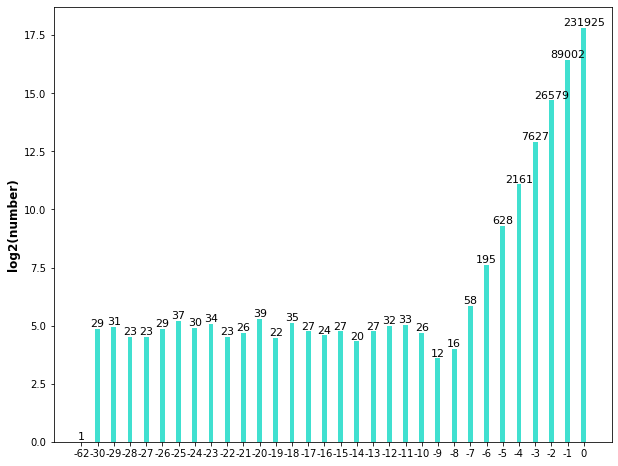

In [63]:
import math
barWidth = 0.3

plt.figure(figsize = (10, 8))
# set height of bar
# becuase some of the weight has too many edges, we use log2
y = [math.log2(n) for n in new_dict.values()]
y_name = new_dict.values()
x_name = new_dict.keys()

# Set position of bar on X axis
bars = [n for n in range(len(y))]

# Make the plot
plt.bar(bars, y, color ='turquoise', width = barWidth)

# Adding Xticks
plt.xticks([r for r in bars], x_name)
plt.ylabel('log2(number)', fontweight ='bold', fontsize = 12)

# Add text
for(a, b, c) in zip(bars, y, y_name):
    plt.text(a, b, '%.0f'%c, ha = 'center', va = 'bottom', fontsize = 11)

#plt.legend()
plt.show()

## Task B: Rationale of Our Simulated Annealing Algorithm
Then we are going to use simulated annealing to find the relatively local solution.
 
Initially, we assemble sequences randomly, just follow the shuffled order, and use that state as our initial input. Then we need to schedule the temperature. We want the accepted probability to be high even if the total path cost of the next state is higher than the current, so that it has more chance to adjust in the beginning. As the number of iterations increases, we are more likely to find a good solution. Since the solution is good enough, then we may conservative to accept higher cost states, so the probability goes lower and lower. In addition, the more attempts we make, the more chances we have to find an ideal solution, so we should make sure that the iteration time is enough.
 
To satisfy our requirement stated above, we set 1000 degree as the initial temperature, using formula $ T = k *{e ^ {(-\lambda * t)}} $ to guarantee that T decreases with iterations t increases. This setting has a huge acceptance probability(over 98% assuming $\Delta E = -15$) at beginning, and after times of iterations, it converges to 0. To control the iteration time, we set the iteration limit to 10000, and for each calculated temperature, we make 100 attempts, which is enough to find a relatively good solution. To be clear, we have tried to set higher attempt times but the effects do not have a significant change while the programme costs much more time. The total cost of the path is around -8300.
 
In addition, we get the next state by randomly picking two sequences and exchanging their position. $\Delta E = Value_{(next)} - Value_{(current)}$, where Value means the total cost of all edges going through in the corresponding state. Because only two sequences have changed, we do not need to calculate the total cost from begining, just calculate those changed sequences is enough where we write in the update_value function. If the next state costs less than the current state, then we accept the change, else, we accept the next state only with probability $e^{\Delta E/T}$.

For a detailed implementation of the method, see `class TSP`.

In [60]:
# intialize sequence
sequences = [i for i in range(len(edges))]
    
tsp = TSP()
res = tsp.simulated_annealing(edges,sequences)
valid_edge = [{} for i in range(len(edges))]
for i,edge in enumerate(edges):
    for j,cost in enumerate(edge):
        if cost != 0:
            valid_edge[i][j] = cost

#calculate the costs of the final solution
costs = []
for i in range(len(res) - 1):
    if res[i + 1] in valid_edge[res[i]]:
        cost = valid_edge[res[i]][res[i+1]]
    else:
        cost = 0
    costs.append(cost)

print("Costs in detail:\n", costs)
print("Result path:\n", res)


Total costs of final solution: -8530
Costs in detail:
 [-11, 0, -2, -13, -22, -2, -20, -1, -20, -26, -22, -1, -13, 0, -29, -10, 0, -17, 0, -30, -17, -4, -3, 0, -27, -1, -26, -2, -24, 0, -25, -30, 0, -23, -20, -26, -1, -15, -29, -1, -18, 0, -10, -28, -8, 0, -22, 0, -26, -30, -1, -29, -29, -3, -19, -18, -2, -4, -12, -6, -6, -22, -11, -2, -17, -29, -20, -1, -25, 0, -23, -25, -29, -1, -24, 0, -15, -20, -1, -21, -2, -24, -62, -20, 0, -28, -11, -16, 0, -20, -22, 0, -25, -24, 0, -21, 0, -30, -30, -29, 0, -26, 0, -30, 0, -24, -26, -4, -25, -15, -18, -1, -20, -17, -2, -12, -16, 0, -21, -1, -18, 0, -24, 0, -22, -17, 0, -18, -5, -27, -4, -26, -1, -23, -30, 0, -10, -30, -15, 0, -15, -20, 0, -24, -2, -14, 0, -20, -1, -28, -2, -30, -19, -1, -17, -28, -28, -19, -1, -27, -23, -23, -1, -23, -1, -11, -20, -23, 0, -27, -23, -2, -20, -26, -12, -3, -17, -29, 0, -29, -20, 0, -26, -28, -1, -25, -28, -23, 0, -24, 0, -11, -23, -17, -18, -2, -12, -10, -17, -11, 0, -12, -15, -30, -23, -25, -1, -26, -15, -24, -21

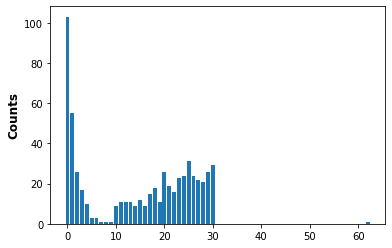

In [62]:
#plot the frequency distribution histogram of each edges' weight of the final resolution
rng = min(set(costs))
stsCosts = [0 for _ in range(-rng+1)]
    
for item in costs:
    stsCosts[-item] += 1
    
plt.bar(range(len(stsCosts)), stsCosts)
plt.ylabel('Counts', fontweight ='bold', fontsize = 12)
plt.show()